In [98]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, BCELoss
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
from tempfile import TemporaryDirectory
import os
from torchvision import transforms
import wandb

In [99]:
LOGGING = False

if(LOGGING):
    wandb.login(key='INSERT_YOUR_KEY')

    wandb.init(
        # set the wandb project where this run will be logged
        project="aml-challenge",
        name="evaluation-ResNet",

        # track hyperparameters
        config={
        "learning_rate": 0.001,
        "architecture": "ResNet",
        "epochs": 50,
        }
    )

In [100]:
# Loading training labels from csv file
import csv
train_labels = {}
with open('../input/aerial-cactus/train.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for rows in reader:
        k = rows[0]
        v = int(rows[1])
        train_labels[k] = v
        
#Check in train_labels the number of k with value 0 or 1
print("Number of images with cactus: ", sum(train_labels.values()))
print("Number of images without cactus: ", len(train_labels) - sum(train_labels.values()))

Number of images with cactus:  13136
Number of images without cactus:  4364


In [101]:
# Define custom dataset to load data
import os
from PIL import Image

class CactusDataset(Dataset):
    def __init__(self, root_dir, train_labels, sampling_strategy=None, augment=False):
        """
        Args:
            root_dir (str): Directory containing the images.
            train_labels (dict): Dictionary mapping file names to labels (0 or 1).
            sampling_strategy (str): Sampling strategy, can be 'undersample', 'oversample' or None.
            augment (bool): Whether to apply augmentation (only applies for oversampling).
        """
        self.root_dir = root_dir
        self.file_list = os.listdir(root_dir)
        self.train_labels = train_labels
        self.sampling_strategy = sampling_strategy
        self.augment = augment
        self.labels = [train_labels[file] for file in self.file_list]
        
        if self.sampling_strategy == 'undersample':
            self.undersample()
        elif self.sampling_strategy == 'oversample':
            self.oversample()
        
        # Define transform for augmentation
        self.augmentation_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor()
        ])
    
    def undersample(self):
        # Find indices for each class
        class_0_idx = [idx for idx, label in enumerate(self.labels) if label == 0]
        class_1_idx = [idx for idx, label in enumerate(self.labels) if label == 1]
        
        # Balance the number of samples for each class
        num_samples_class_0 = len(class_0_idx)
        indices_to_take = np.random.choice(class_1_idx, size=num_samples_class_0, replace=False)
        samples = np.append(indices_to_take, class_0_idx)
        
        # Update file list and labels with the undersampled set
        self.file_list = [self.file_list[idx] for idx in samples]
        self.labels = [self.labels[idx] for idx in samples]
    
    def oversample(self):
        # Find indices for each class
        class_0_idx = [idx for idx, label in enumerate(self.labels) if label == 0]
        class_1_idx = [idx for idx, label in enumerate(self.labels) if label == 1]
        
        # Balance the number of samples for each class
        num_samples_class_1 = len(class_1_idx)
        num_samples_to_augment = num_samples_class_1 - len(class_0_idx)
        
        # Augment class 0 samples to match class 1
        indices_to_augment = np.random.choice(class_0_idx, size=num_samples_to_augment, replace=True)
        self.file_list += [self.file_list[idx] for idx in indices_to_augment]
        self.labels += [0] * num_samples_to_augment

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Gets the next image from the directory
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = os.path.join(self.root_dir, self.file_list[idx])
        
        # Open image and convert to numpy array
        img = Image.open(file_name)
        data = np.asarray(img).copy()
        
        # Transform image to tensor
        image = torch.from_numpy(data).permute(2, 0, 1).float()
        label = self.train_labels[self.file_list[idx]]
        
        # Apply augmentation if oversampling and class label is 0
        if label == 0 and self.augment and self.sampling_strategy == 'oversample':
            image = self.augmentation_transform(image)
        
        return image, label, file_name

In [102]:
from torch.utils.data import random_split
from torchvision.transforms import v2
from torchvision import transforms

# Need to get mean and std for each channel of the images in the train dataloaders
def get_mean_std(dataset):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = torch.tensor([0.0,0.0,0.0])
    std = torch.tensor([0.0,0.0,0.0])
    count = 0
    
    for images, _, _ in dataset:
        count += 1
        num_channels, height, width = images.shape
        num_pixels += height * width
        
        mean += images.mean(axis=(1, 2))
        std += images.std(axis=(1, 2))

    mean /= count
    std /= count

    return mean, std

dataset = CactusDataset(root_dir='../input/aerial-cactus/train/train/', train_labels=train_labels)
percentages = [0.7, 0.2, 0.1]
train, valid, test = random_split(dataset, percentages)

print(f"Train len is {len(train)}")

Train len is 12250


In [103]:
# Creating the DataLoader
BATCH_SIZE = 16
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {'train':train_dataloader, 'valid':valid_dataloader, 'test':test_dataloader}
dataset_sizes = {'train': len(train), 'valid':len(valid), 'test':len(test)}

In [104]:
# Defining the model
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)

cuda


In [105]:
# Adjust the model for fine tuning
num_class = 2

# The number of input features that the last fully connected layer expects
num_features = model.fc.in_features #512

# Freeze only the convolutional layers of the pre-trained model
for param in model.parameters():
    if isinstance(param, nn.Conv2d):
        param.requires_grad = False

# Adding more layers
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Additional linear layer with 256 output features
    nn.ReLU(inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.3),               # Dropout layer with 30% probability
    nn.Linear(256, num_class)     # Final prediction fc layer
).to(device)

In [110]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    losses = {
        'train': [],
        'valid': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for images, labels, _ in dataloaders[phase]:
                    images = images.to(device, dtype=torch.float)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() 
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                precision = precision_score(labels.cpu().numpy(), preds.cpu().numpy())
                recall = recall_score(labels.cpu().numpy(), preds.cpu().numpy())
                f1score = f1_score(labels.cpu().numpy(), preds.cpu().numpy())

                #bar.set_postfix(loss = epoch_loss, acc= epoch_acc.item(), precision= precision, recall= recall, f1score= f1score)
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1Score: {f1score:.4f}')

                losses[phase].append(epoch_loss)
                
                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True),strict=False)
    return model, losses

In [111]:
#Train the model
LEARNING_RATE = 1e-3
EPOCHS = 30
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, losses = train_model(model, criterion, optimizer, exp_lr_scheduler, EPOCHS)

Epoch 0/29
----------
train Loss: 0.0042 Acc: 0.9809 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000
valid Loss: 0.0031 Acc: 0.9860 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000

Epoch 1/29
----------
train Loss: 0.0040 Acc: 0.9804 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000
valid Loss: 0.0089 Acc: 0.9369 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000

Epoch 2/29
----------
train Loss: 0.0040 Acc: 0.9849 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000
valid Loss: 0.0031 Acc: 0.9877 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000

Epoch 3/29
----------
train Loss: 0.0024 Acc: 0.9891 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000
valid Loss: 0.0025 Acc: 0.9849 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000

Epoch 4/29
----------
train Loss: 0.0028 Acc: 0.9871 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000
valid Loss: 0.0030 Acc: 0.9869 Precision: 1.0000 Recall: 1.0000 F1Score: 1.0000

Epoch 5/29
----------
train Loss: 0.0044 Acc: 0.9787 Precision: 1.0000 Recall: 1.0000

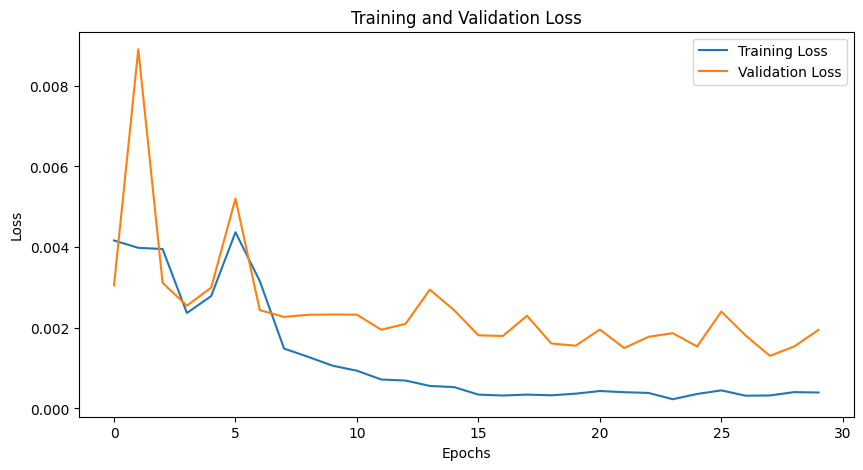

In [112]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['valid'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()